<a href="https://colab.research.google.com/github/Gugo-le/103-zoom/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 임베딩을 사용한 감성 프로그래밍

In [30]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

mkdir: cannot create directory ‘../ch05’: File exists


In [31]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [32]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [33]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-33-26e5c469036e>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [34]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [35]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [36]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## 임베딩을 사용해 빈정거림 감지기 만들기

In [37]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5634 - loss: 0.6848 - val_accuracy: 0.5700 - val_loss: 0.6770
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5802 - loss: 0.6720 - val_accuracy: 0.6535 - val_loss: 0.6390
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7080 - loss: 0.5777 - val_accuracy: 0.7304 - val_loss: 0.5329
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7887 - loss: 0.4578 - val_accuracy: 0.7905 - val_loss: 0.4471
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8151 - loss: 0.3993 - val_accuracy: 0.7867 - val_loss: 0.4547
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8499 - loss: 0.3471 - val_accuracy: 0.8005 - val_loss: 0.4267
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8598 - loss: 0.3225 - val_accuracy: 0.8075 - val_loss: 0.4209
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8673 - loss: 0.3071 - val_accuracy: 0.

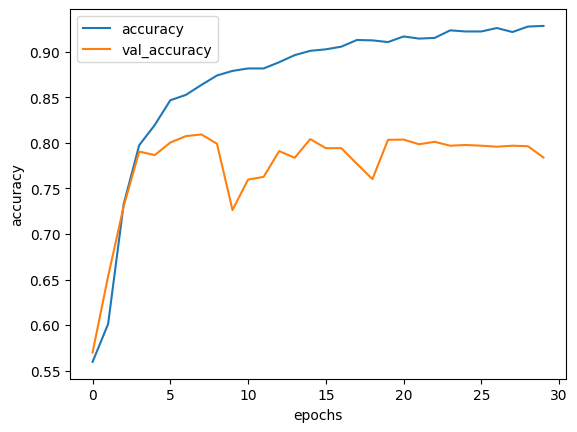

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

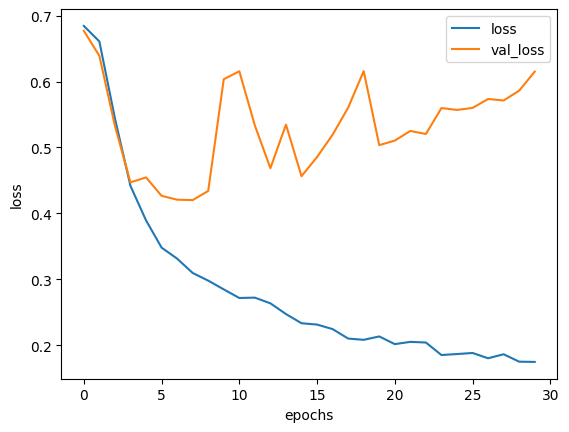

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## 언어 모델의 과대적합 줄이기

In [43]:
# 과대적함을 일으키는 가장 큰 요소는 옵티마이저의 학습률이 너무 높은 경우이다.(신경망이 너무 빠르게 학습한다는 의미)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001,
                               beta_1=0.9, beta_2=0.999, amsgrad=False) # amsgrad는 adam의 또 다른 구현,beta의 값은 0~1사이, 일반적으로 1에 가깝게 설정함.
model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5536 - loss: 0.6885 - val_accuracy: 0.5700 - val_loss: 0.6825
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5661 - loss: 0.6834 - val_accuracy: 0.5700 - val_loss: 0.6826
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5585 - loss: 0.6852 - val_accuracy: 0.5700 - val_loss: 0.6816
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5595 - loss: 0.6844 - val_accuracy: 0.5700 - val_loss: 0.6812
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5553 - loss: 0.6847 - val_accuracy: 0.5700 - val_loss: 0.6810
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5585 - loss: 0.6829 - val_accuracy: 0.5700 - val_loss: 0.6790
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5609 - loss: 0.6809 - val_accuracy: 0.5700 - val_loss: 0.6773
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5596 - loss: 0.6791 - val_accu

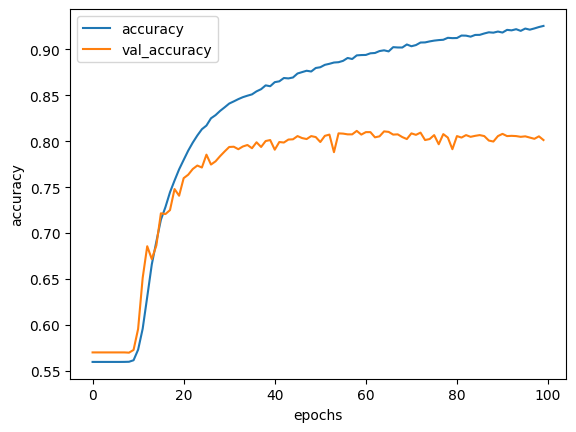

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

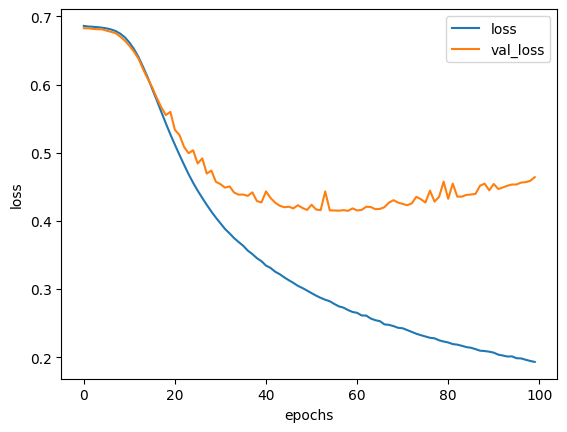

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()